# Swarm Optimization with GNN Training

Complete implementation for training a Graph Neural Network to optimize swarm positions.

**Approach**: Train a neural network to learn how to transform positions optimally.

---

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

Using device: cpu


## 2. Data Generation Utilities

In [2]:
def generate_agent_positions(num_agents, grid_size=1000):
    """Generate random agent positions"""
    positions = (np.random.rand(num_agents, 2) * 200) + 400
    return positions


def add_graph_features(data, max_distance):
    """Add additional features to graph nodes"""
    positions = data.x
    num_nodes = positions.shape[0]
    
    # Calculate degrees
    edge_index = data.edge_index
    degrees = torch.zeros(num_nodes, 1)
    unique, counts = torch.unique(edge_index[0], return_counts=True)
    degrees[unique] = counts.float().unsqueeze(1)
    
    # Calculate average distance to neighbors
    avg_distances = torch.zeros(num_nodes, 1)
    for i in range(num_nodes):
        neighbors = edge_index[1][edge_index[0] == i]
        if len(neighbors) > 0:
            dists = torch.norm(positions[neighbors] - positions[i], dim=1)
            avg_distances[i] = dists.mean()
    
    # Normalized degree
    normalized_degrees = degrees / (num_nodes - 1) if num_nodes > 1 else degrees
    
    # Combine features: [x, y, degree, avg_distance, normalized_degree]
    features = torch.cat([
        positions,
        degrees,
        avg_distances,
        normalized_degrees
    ], dim=1)
    
    data.x = features
    return data


def generate_graph_dataset(num_graphs, min_agents, max_agents, max_distance, grid_size=1000):
    """Generate a dataset of graphs"""
    graphs = []
    
    for i in range(num_graphs):
        num_nodes = np.random.randint(min_agents, max_agents + 1)
        positions = generate_agent_positions(num_nodes, grid_size)
        
        # Build adjacency based on distance
        distances = np.linalg.norm(positions[:, None, :] - positions[None, :, :], axis=-1)
        W = (distances < max_distance).astype(float)
        np.fill_diagonal(W, 0)
        
        # Create edge index
        edge_index = torch.tensor(np.array(np.nonzero(W)), dtype=torch.long)
        
        # Create node features (initially just positions)
        x = torch.tensor(positions, dtype=torch.float)
        
        # Create Data object
        data = Data(x=x, edge_index=edge_index)
        data.original_positions = torch.tensor(positions, dtype=torch.float)
        
        # Add graph features
        data = add_graph_features(data, max_distance)
        
        graphs.append(data)
    
    return graphs

print("✓ Data generation utilities defined")

✓ Data generation utilities defined


## 3. GNN Model Definition

In [3]:
class GenerativeGNN(nn.Module):
    """Graph Neural Network for generating optimized positions"""
    
    def __init__(self, input_dim, output_dim, hidden_dim=16):
        super(GenerativeGNN, self).__init__()
        
        # Graph convolution layers using SAGEConv
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim // 2, hidden_dim // 2)
        self.conv4 = SAGEConv(hidden_dim // 2, hidden_dim // 2)
        
        # Linear layer for output
        self.linear = nn.Linear(hidden_dim // 2, output_dim)
    
    def forward(self, x, edge_index):
        """Forward pass through the GNN"""
        # Normalize input to [-0.5, 0.5] range
        x = x / 1000 - 0.5
        
        # First convolution with sin activation
        x = torch.sin(self.conv1(x, edge_index))
        
        # Second convolution (no activation)
        x = self.conv2(x, edge_index)
        
        # Split into mean and log_var for VAE
        mean = x[:, :x.shape[1] // 2]
        log_var = x[:, x.shape[1] // 2:]
        
        # Reparameterization trick
        epsilon = torch.randn_like(log_var).to(x.device)
        z = mean + torch.exp(log_var) * epsilon
        
        # Decoder layers
        x = torch.relu(self.conv3(z, edge_index))
        x = torch.relu(self.conv4(x, edge_index))
        
        # Output layer with sigmoid to constrain to [0, 1000] range
        optimized_positions = torch.sigmoid(self.linear(x)) * 1000
        
        return optimized_positions, mean, log_var

print("✓ GNN model defined")

✓ GNN model defined


## 4. Loss Functions

In [4]:
class DomainOfDangerLoss(nn.Module):
    """Penalizes positions in danger zones"""
    def __init__(self, r, grid_size):
        super(DomainOfDangerLoss, self).__init__()
        self.r = r
        self.grid_size = grid_size
    
    def distance(self, xx, yy, px, py):
        return torch.sqrt((xx - px).pow(2) + (yy - py).pow(2) + 1e-6)
    
    def forward(self, positions):
        width, height = self.grid_size, self.grid_size
        num_nodes = positions.shape[0]
        danger_zone = torch.zeros((width, height), dtype=torch.float32, device=positions.device)
        x = torch.arange(0, width, device=positions.device)
        y = torch.arange(0, height, device=positions.device)
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        xx, yy = xx.float(), yy.float()
        for i in range(num_nodes):
            px, py = positions[i]
            dist = self.distance(xx, yy, px, py)
            danger_zone += torch.sigmoid(-1 * (dist - self.r))
        return torch.mean(torch.sigmoid(danger_zone))


class MinimalChangeLoss(nn.Module):
    """Penalizes movement from original positions"""
    def __init__(self):
        super(MinimalChangeLoss, self).__init__()
        self.mse_loss_fn = nn.MSELoss()
    
    def forward(self, original_positions, optimized_positions):
        spatial_original = original_positions[:, :2]  # Extract x, y from features
        return self.mse_loss_fn(spatial_original, optimized_positions)


class DiffusionLoss(nn.Module):
    """Encourages spreading out using heat kernel"""
    def __init__(self, taus=[5.0, 10.0], max_distance=50):
        super(DiffusionLoss, self).__init__()
        self.taus = taus
        self.max_distance = max_distance
    
    def forward(self, optimized_positions):
        num_nodes = optimized_positions.shape[0]
        distances = torch.cdist(optimized_positions, optimized_positions)
        adjacency_matrix = torch.sigmoid(-1 * (1 / self.max_distance) * (distances - self.max_distance))
        adjacency_matrix = adjacency_matrix - torch.diag(torch.diag(adjacency_matrix))
        degree_matrix = torch.diag(torch.sum(adjacency_matrix, dim=1))
        laplacian = degree_matrix - adjacency_matrix
        degree_inv_sqrt = torch.diag(1.0 / torch.sqrt(torch.sum(adjacency_matrix, dim=1) + 1e-6))
        normalized_laplacian = torch.mm(degree_inv_sqrt, torch.mm(laplacian, degree_inv_sqrt))
        total_loss = 0.0
        for tau in self.taus:
            heat_filter = torch.matrix_exp(-tau * normalized_laplacian)
            for i in range(num_nodes):
                delta_signal = torch.zeros(num_nodes, device=optimized_positions.device, dtype=optimized_positions.dtype)
                delta_signal = delta_signal.scatter(0, torch.tensor([i % num_nodes], device=optimized_positions.device), 1.0)
                smoothed_signal = torch.mv(heat_filter, delta_signal)
                coeff_var = torch.std(smoothed_signal) / (torch.mean(smoothed_signal) + 1e-6)
                total_loss += coeff_var
        return total_loss / (num_nodes * len(self.taus))


class KLD(nn.Module):
    """Kullback-Leibler Divergence for VAE"""
    def __init__(self):
        super(KLD, self).__init__()
    
    def forward(self, mean, log_var):
        return -0.5 * torch.mean(1 + log_var - mean.pow(2) - log_var.exp())


class RepulsionLoss(nn.Module):
    """Prevents agents from getting too close"""
    def __init__(self, min_distance=5.0):
        super(RepulsionLoss, self).__init__()
        self.min_distance = min_distance
    
    def forward(self, positions):
        distances = torch.cdist(positions, positions)
        mask = torch.eye(distances.size(0), device=distances.device).bool()
        distances = distances.masked_fill(mask, float('inf'))
        violations = torch.relu(self.min_distance - distances)
        return violations.sum() / (positions.size(0) ** 2)

print("✓ All loss functions defined")

✓ All loss functions defined


## 5. Training Function

In [5]:
def train_gnn(model, train_loader, optimizer, loss_functions, loss_weights,
              epochs, device, tau_decay=0.9, verbose=True):
    """
    Train the GNN model.
    
    Parameters:
    -----------
    model : GenerativeGNN
        The GNN model to train
    train_loader : DataLoader
        DataLoader with training graphs
    optimizer : torch.optim.Optimizer
        Optimizer for training
    loss_functions : dict
        Dictionary of loss functions
    loss_weights : dict
        Dictionary of loss weights
    epochs : int
        Number of training epochs
    device : torch.device
        Device to train on
    tau_decay : float
        Decay factor for alpha weight
    verbose : bool
        Print training progress
    """
    
    model.to(device)
    model.train()
    
    # Track losses
    history = {
        'total': [],
        'domain': [],
        'minimal_change': [],
        'diffusion': [],
        'kld': [],
        'repulsion': []
    }
    
    if verbose:
        print(f"Training GNN for {epochs} epochs")
        print(f"Dataset size: {len(train_loader.dataset)} graphs")
        print(f"Batch size: {train_loader.batch_size}")
        print("="*80)
    
    curr_alpha = loss_weights['alpha']
    
    for epoch in range(epochs):
        epoch_losses = {
            'total': 0.0,
            'domain': 0.0,
            'minimal_change': 0.0,
            'diffusion': 0.0,
            'kld': 0.0,
            'repulsion': 0.0
        }
        
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            original_positions = data.original_positions
            edge_index = data.edge_index
            optimized_positions, mean, log_var = model(data.x, edge_index)
            
            # Compute losses
            dod_loss = loss_functions['domain'](optimized_positions)
            mc_loss = loss_functions['minimal_change'](original_positions, optimized_positions)
            diff_loss = loss_functions['diffusion'](optimized_positions)
            kld_loss = loss_functions['kld'](mean, log_var)
            repulse_loss = loss_functions['repulsion'](optimized_positions)
            
            # Combined loss
            loss = (curr_alpha * mc_loss + 
                   loss_weights['beta'] * dod_loss - 
                   loss_weights['gamma'] * diff_loss + 
                   loss_weights['delta'] * kld_loss + 
                   loss_weights['epsilon'] * repulse_loss)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Track losses
            epoch_losses['total'] += loss.item()
            epoch_losses['domain'] += dod_loss.item()
            epoch_losses['minimal_change'] += mc_loss.item()
            epoch_losses['diffusion'] += diff_loss.item()
            epoch_losses['kld'] += kld_loss.item()
            epoch_losses['repulsion'] += repulse_loss.item()
        
        # Average losses
        for key in epoch_losses:
            epoch_losses[key] /= len(train_loader)
            history[key].append(epoch_losses[key])
        
        # Decay alpha
        curr_alpha = loss_weights['alpha'] * (tau_decay ** epoch)
        
        # Print progress
        if verbose and ((epoch + 1) % 5 == 0 or epoch == 0):
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Loss: {epoch_losses['total']:7.4f} | "
                  f"Domain: {epoch_losses['domain']:6.4f} | "
                  f"MC: {epoch_losses['minimal_change']:6.4f} | "
                  f"Diff: {epoch_losses['diffusion']:6.4f} | "
                  f"KLD: {epoch_losses['kld']:6.4f} | "
                  f"Rep: {epoch_losses['repulsion']:6.4f}")
    
    if verbose:
        print("="*80)
        print("✓ Training complete!")
    
    return model, history

print("✓ Training function defined")

✓ Training function defined


## 6. Visualization Functions

In [6]:
def plot_training_losses(history, title="Training Loss History"):
    """Plot training loss curves"""
    fig, axes = plt.subplots(2, 3, figsize=(16, 8))
    axes = axes.flatten()
    
    colors = ['purple', 'red', 'blue', 'orange', 'green', 'brown']
    
    for idx, (name, values) in enumerate(history.items()):
        if idx < len(axes):
            axes[idx].plot(values, color=colors[idx], linewidth=2)
            axes[idx].set_title(f'{name.replace("_", " ").title()} Loss', 
                              fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Epoch')
            axes[idx].set_ylabel('Loss')
            axes[idx].grid(True, alpha=0.3)
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


def visualize_swarm(positions, title="Swarm", ax=None, color='blue', s=100):
    """Visualize a single swarm"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    positions_np = positions.detach().cpu().numpy() if torch.is_tensor(positions) else positions
    
    ax.scatter(positions_np[:, 0], positions_np[:, 1], s=s, alpha=0.6, 
              c=color, edgecolors='black', linewidths=1.5)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    return ax


def plot_comparison(original, optimized, title="Swarm Optimization"):
    """Plot before and after comparison"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    visualize_swarm(original, "Before Optimization", ax=axes[0], color='blue')
    visualize_swarm(optimized, "After Optimization", ax=axes[1], color='green')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


def plot_movement(original, optimized, title="Agent Movement"):
    """Plot movement vectors"""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Convert to numpy if needed
    original_np = original.detach().cpu().numpy() if torch.is_tensor(original) else original
    optimized_np = optimized.detach().cpu().numpy() if torch.is_tensor(optimized) else optimized
    
    ax.scatter(original_np[:, 0], original_np[:, 1], s=100, alpha=0.4, 
              c='blue', edgecolors='black', label='Before', zorder=2)
    ax.scatter(optimized_np[:, 0], optimized_np[:, 1], s=100, alpha=0.7, 
              c='green', edgecolors='black', label='After', zorder=3)
    
    # Draw arrows
    for i in range(len(original_np)):
        dx = optimized_np[i, 0] - original_np[i, 0]
        dy = optimized_np[i, 1] - original_np[i, 1]
        if np.sqrt(dx**2 + dy**2) > 1:
            ax.arrow(original_np[i, 0], original_np[i, 1], dx, dy,
                    head_width=10, head_length=15, fc='red', ec='red', 
                    alpha=0.5, zorder=1)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()


def print_statistics(original, optimized):
    """Print statistics about optimization"""
    # Convert to numpy if needed
    original_np = original.detach().cpu().numpy() if torch.is_tensor(original) else original
    optimized_np = optimized.detach().cpu().numpy() if torch.is_tensor(optimized) else optimized
    
    displacement = np.linalg.norm(optimized_np - original_np, axis=1)
    
    print("\n" + "="*60)
    print("OPTIMIZATION STATISTICS")
    print("="*60)
    print(f"Number of agents: {len(original_np)}")
    print(f"\nDisplacement:")
    print(f"  Mean:   {displacement.mean():.2f}")
    print(f"  Median: {np.median(displacement):.2f}")
    print(f"  Max:    {displacement.max():.2f}")
    print(f"  Min:    {displacement.min():.2f}")
    
    # Pairwise distances
    original_dists = np.linalg.norm(original_np[:, None, :] - original_np[None, :, :], axis=-1)
    optimized_dists = np.linalg.norm(optimized_np[:, None, :] - optimized_np[None, :, :], axis=-1)
    original_dists = original_dists[~np.eye(len(original_np), dtype=bool)]
    optimized_dists = optimized_dists[~np.eye(len(optimized_np), dtype=bool)]
    
    print(f"\nPairwise Distances:")
    print(f"  Original  - Mean: {original_dists.mean():.2f}, Min: {original_dists.min():.2f}")
    print(f"  Optimized - Mean: {optimized_dists.mean():.2f}, Min: {optimized_dists.min():.2f}")
    print("="*60)

print("✓ Visualization functions defined")

✓ Visualization functions defined


---

# 7. EXAMPLE: Train GNN on Swarm Dataset

Now let's train a GNN to optimize swarms!

## 7.1 Configuration

In [7]:
# ====================
# CONFIGURATION
# ====================

# Dataset parameters
NUM_TRAIN_GRAPHS = 100  # Number of training graphs
NUM_TEST_GRAPHS = 50    # Number of test graphs
MIN_AGENTS = 30         # Minimum agents per graph
MAX_AGENTS = 60         # Maximum agents per graph
MAX_DISTANCE = 50.0     # Maximum connection distance
GRID_SIZE = 1000        # Grid size

# Model parameters
INPUT_DIM = 5           # [x, y, degree, avg_dist, norm_degree]
OUTPUT_DIM = 2          # [x, y]
HIDDEN_DIM = 16         # Hidden layer size

# Training parameters
EPOCHS = 25
BATCH_SIZE = 1
LEARNING_RATE = 0.01
TAU_DECAY = 0.9

# Loss weights
ALPHA = 0.001    # Minimal change
BETA = 17.0      # Domain of danger
GAMMA = 2.0      # Diffusion
DELTA = 1.0      # KLD
EPSILON = 1.0    # Repulsion

# Loss function parameters
TAUS = [1.0, 5.0, 10.0]
MIN_DISTANCE = 5.0

print("Configuration set!")
print(f"  Training graphs: {NUM_TRAIN_GRAPHS}")
print(f"  Test graphs: {NUM_TEST_GRAPHS}")
print(f"  Agents per graph: {MIN_AGENTS}-{MAX_AGENTS}")
print(f"  Epochs: {EPOCHS}")

Configuration set!
  Training graphs: 100
  Test graphs: 50
  Agents per graph: 30-60
  Epochs: 25


## 7.2 Generate Dataset

In [8]:
print("Generating dataset...")

# Generate training and test datasets
train_graphs = generate_graph_dataset(
    NUM_TRAIN_GRAPHS, MIN_AGENTS, MAX_AGENTS, MAX_DISTANCE, GRID_SIZE
)

test_graphs = generate_graph_dataset(
    NUM_TEST_GRAPHS, MIN_AGENTS, MAX_AGENTS, MAX_DISTANCE, GRID_SIZE
)

# Create data loaders
train_loader = DataLoader(train_graphs, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=BATCH_SIZE, shuffle=False)

print(f"✓ Dataset generated")
print(f"  Training graphs: {len(train_graphs)}")
print(f"  Test graphs: {len(test_graphs)}")
print(f"  Sample graph: {train_graphs[0].x.shape[0]} agents, {train_graphs[0].edge_index.shape[1]} edges")

Generating dataset...
✓ Dataset generated
  Training graphs: 100
  Test graphs: 50
  Sample graph: 36 agents, 178 edges


/Users/jonathankarin/miniforge3/envs/bioenv1/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 7.3 Visualize Sample Graph

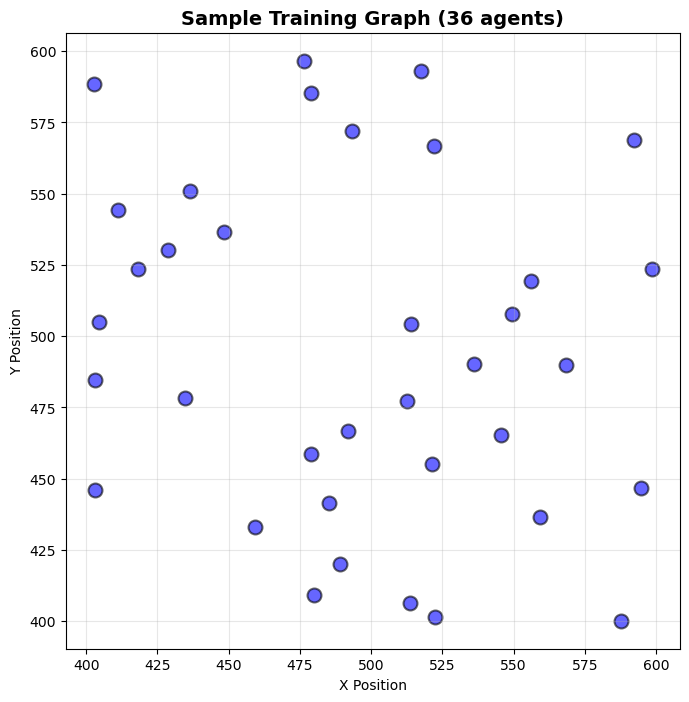

In [9]:
# Visualize a sample graph from the dataset
sample_graph = train_graphs[0]
visualize_swarm(sample_graph.original_positions, 
               title=f"Sample Training Graph ({sample_graph.x.shape[0]} agents)")
plt.show()

## 7.4 Initialize Model and Loss Functions

In [10]:
# Initialize model
model = GenerativeGNN(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    hidden_dim=HIDDEN_DIM,
)

# Initialize optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Initialize loss functions
loss_functions = {
    'domain': DomainOfDangerLoss(MAX_DISTANCE, GRID_SIZE),
    'minimal_change': MinimalChangeLoss(),
    'diffusion': DiffusionLoss(TAUS, MAX_DISTANCE),
    'kld': KLD(),
    'repulsion': RepulsionLoss(MIN_DISTANCE)
}

# Loss weights
loss_weights = {
    'alpha': ALPHA,
    'beta': BETA,
    'gamma': GAMMA,
    'delta': DELTA,
    'epsilon': EPSILON
}

print("✓ Model initialized")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

✓ Model initialized
  Total parameters: 994
  Trainable parameters: 994


## 7.5 Train Model

In [11]:
print("\nStarting training...\n")

model, history = train_gnn(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    loss_functions=loss_functions,
    loss_weights=loss_weights,
    epochs=EPOCHS,
    device=device,
    tau_decay=TAU_DECAY,
    verbose=True
)


Starting training...

Training GNN for 25 epochs
Dataset size: 100 graphs
Batch size: 1
Epoch   1/25 | Loss:  9.2675 | Domain: 0.5144 | MC: 2039.6275 | Diff: 0.8445 | KLD: 0.1194 | Rep: 0.0531
Epoch   5/25 | Loss:  7.5946 | Domain: 0.5236 | MC: 377.5006 | Diff: 0.8767 | KLD: 0.1539 | Rep: 0.0184
Epoch  10/25 | Loss:  7.4513 | Domain: 0.5231 | MC: 416.9429 | Diff: 0.8776 | KLD: 0.1149 | Rep: 0.0188
Epoch  15/25 | Loss:  7.3592 | Domain: 0.5217 | MC: 557.2531 | Diff: 0.8757 | KLD: 0.0804 | Rep: 0.0191
Epoch  20/25 | Loss:  7.3138 | Domain: 0.5200 | MC: 1315.2880 | Diff: 0.9065 | KLD: 0.0660 | Rep: 0.0240
Epoch  25/25 | Loss:  7.1509 | Domain: 0.5191 | MC: 4048.1336 | Diff: 1.0687 | KLD: 0.0701 | Rep: 0.0349
✓ Training complete!


## 7.6 Plot Training History

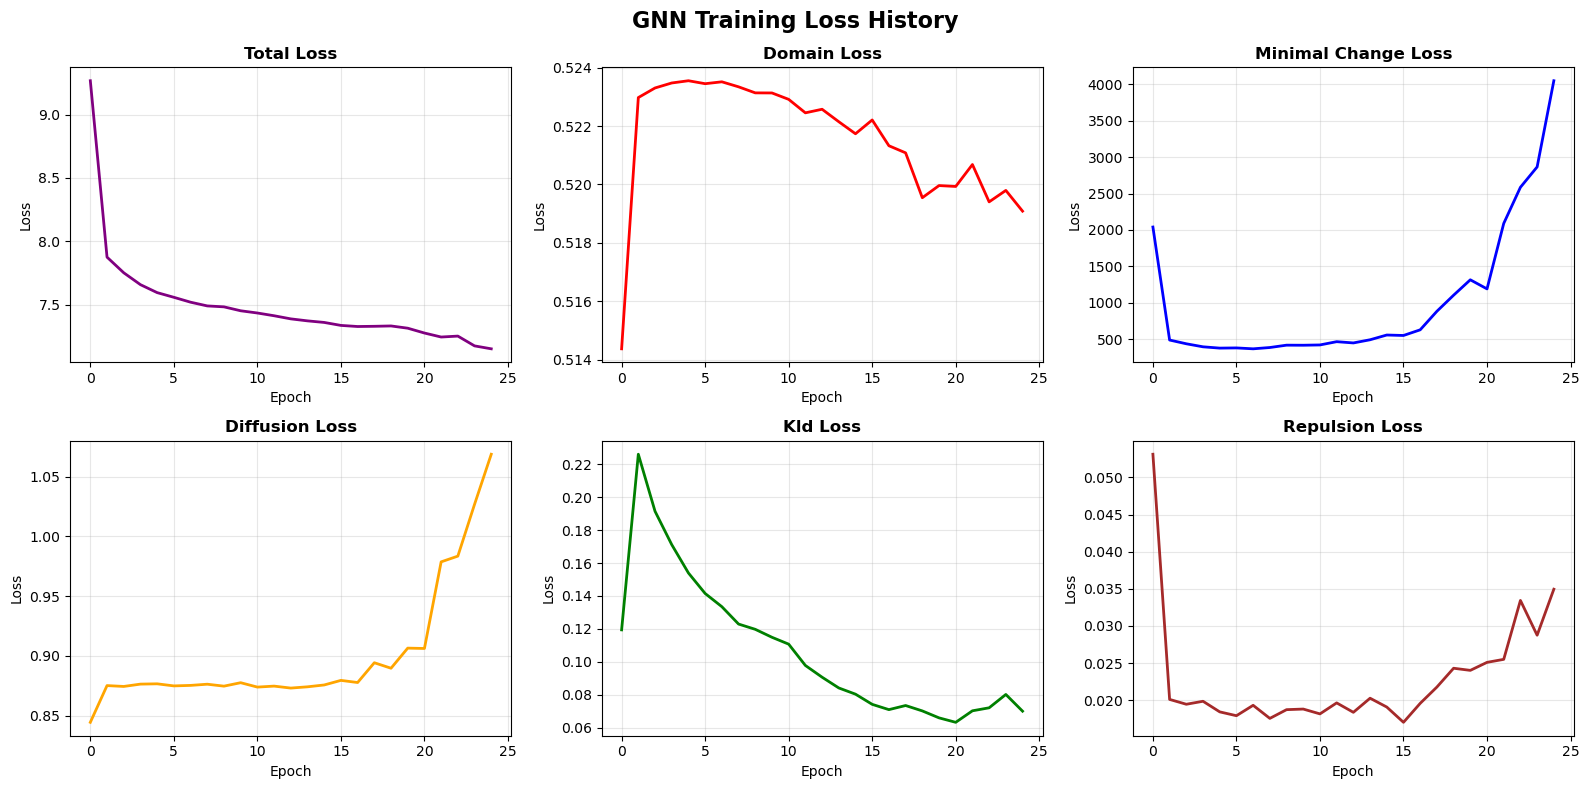

In [12]:
plot_training_losses(history, title="GNN Training Loss History")

## 7.7 Test on Sample Graph

In [13]:
# Test on a sample graph
model.eval()

with torch.no_grad():
    test_graph = test_graphs[0].to(device)
    original_positions = test_graph.original_positions
    
    # Forward pass
    optimized_positions, mean, log_var = model(test_graph.x, test_graph.edge_index)
    
    # Move to CPU for visualization
    original_positions = original_positions.cpu()
    optimized_positions = optimized_positions.cpu()
    
    print(f"Test graph: {len(original_positions)} agents")
    print(f"Original position range: X=[{original_positions[:, 0].min():.1f}, {original_positions[:, 0].max():.1f}], "
          f"Y=[{original_positions[:, 1].min():.1f}, {original_positions[:, 1].max():.1f}]")
    print(f"Optimized position range: X=[{optimized_positions[:, 0].min():.1f}, {optimized_positions[:, 0].max():.1f}], "
          f"Y=[{optimized_positions[:, 1].min():.1f}, {optimized_positions[:, 1].max():.1f}]")

Test graph: 34 agents
Original position range: X=[409.5, 590.8], Y=[408.2, 585.5]
Optimized position range: X=[427.9, 747.2], Y=[445.6, 621.1]


## 7.8 Visualize Results

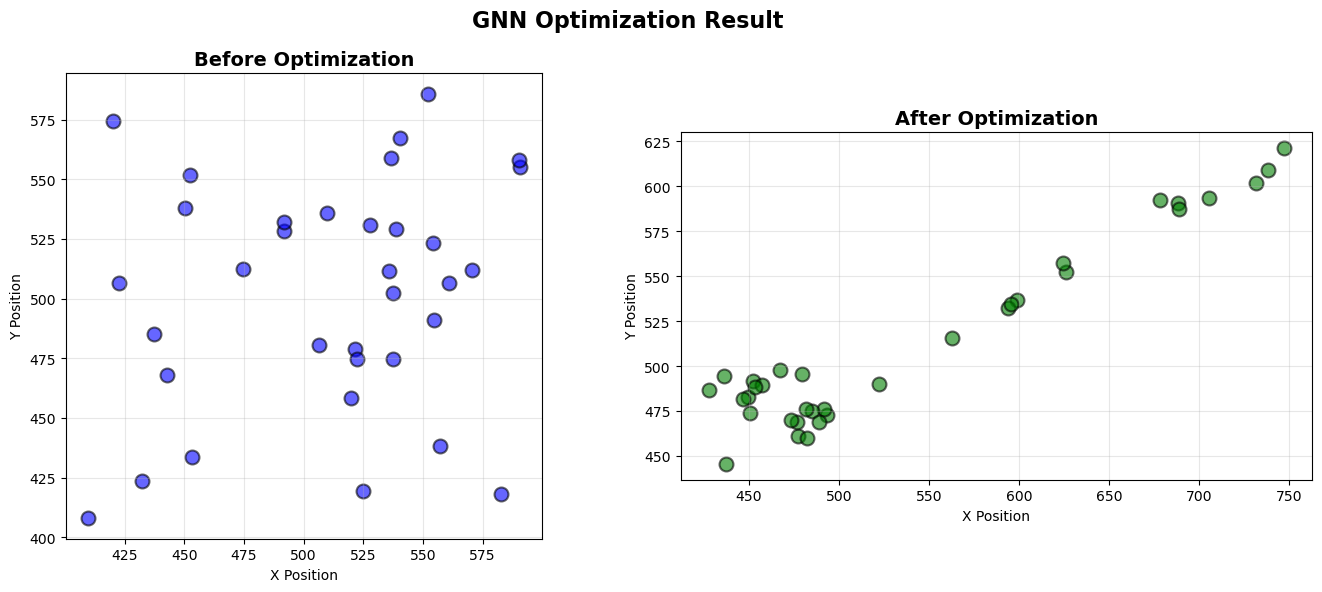

In [14]:
# Before vs After
plot_comparison(original_positions, optimized_positions, 
               title="GNN Optimization Result")

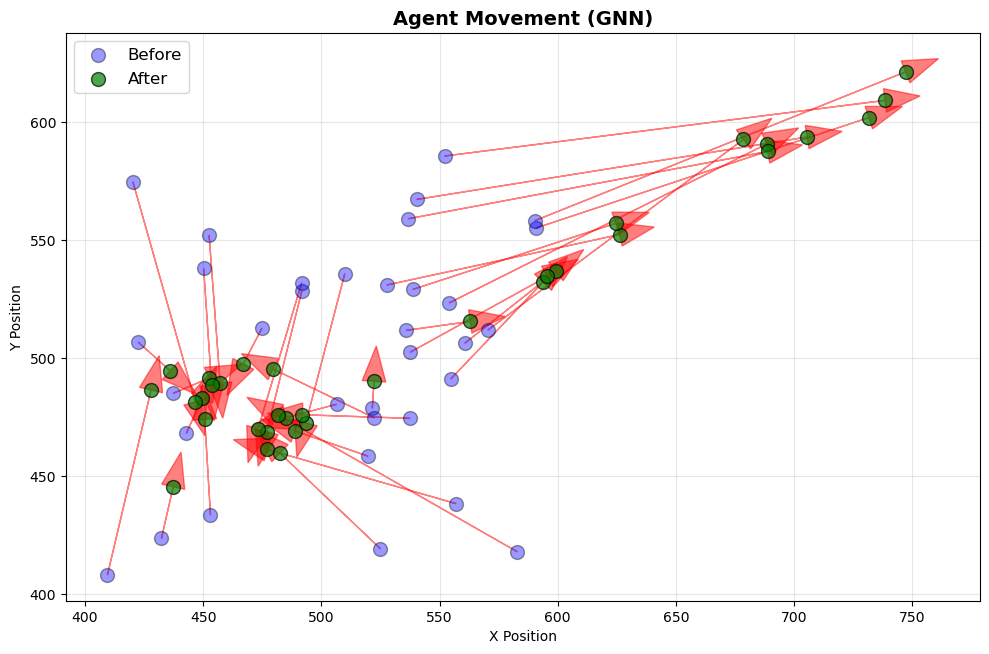

In [15]:
# Movement vectors
plot_movement(original_positions, optimized_positions,
             title="Agent Movement (GNN)")

In [16]:
# Statistics
print_statistics(original_positions, optimized_positions)


OPTIMIZATION STATISTICS
Number of agents: 34

Displacement:
  Mean:   74.45
  Median: 62.05
  Max:    187.83
  Min:    11.40

Pairwise Distances:
  Original  - Mean: 90.57, Min: 3.16
  Optimized - Mean: 128.30, Min: 3.03


## 7.9 Test on Multiple Graphs

In [17]:
# Test on all test graphs and compute average displacement
model.eval()

all_displacements = []

print("Testing on all test graphs...\n")

with torch.no_grad():
    for idx, test_graph in enumerate(test_graphs):
        test_graph = test_graph.to(device)
        original_positions = test_graph.original_positions
        optimized_positions, _, _ = model(test_graph.x, test_graph.edge_index)
        
        # Compute displacement
        displacement = torch.norm(optimized_positions - original_positions.to(device), dim=1)
        mean_displacement = displacement.mean().item()
        all_displacements.append(mean_displacement)
        
        print(f"Graph {idx+1}: {len(original_positions)} agents, "
              f"mean displacement: {mean_displacement:.2f}")

print(f"\nOverall mean displacement: {np.mean(all_displacements):.2f}")
print(f"Std displacement: {np.std(all_displacements):.2f}")

Testing on all test graphs...

Graph 1: 34 agents, mean displacement: 71.13
Graph 2: 31 agents, mean displacement: 74.88
Graph 3: 48 agents, mean displacement: 69.21
Graph 4: 59 agents, mean displacement: 74.64
Graph 5: 53 agents, mean displacement: 67.39
Graph 6: 54 agents, mean displacement: 66.90
Graph 7: 51 agents, mean displacement: 82.87
Graph 8: 44 agents, mean displacement: 88.34
Graph 9: 43 agents, mean displacement: 66.67
Graph 10: 30 agents, mean displacement: 114.67
Graph 11: 31 agents, mean displacement: 70.20
Graph 12: 47 agents, mean displacement: 111.34
Graph 13: 31 agents, mean displacement: 90.37
Graph 14: 33 agents, mean displacement: 69.85
Graph 15: 34 agents, mean displacement: 69.69
Graph 16: 35 agents, mean displacement: 88.17
Graph 17: 52 agents, mean displacement: 75.80
Graph 18: 59 agents, mean displacement: 77.48
Graph 19: 38 agents, mean displacement: 80.54
Graph 20: 36 agents, mean displacement: 75.06
Graph 21: 57 agents, mean displacement: 77.15
Graph 22: 

## Calculate GW distance

In [18]:
import numpy as np
import shapes
import matplotlib.pyplot as plt
from IPython import display
from matplotlib import animation
import scipy as sp



import numpy as np
import ot

# Function to calculate L2 Gromov-Wasserstein distance
def gromov_wasserstein_distance(pos1, pos2):
    # Compute the pairwise L2 distance matrices
    C1 = sp.spatial.distance.cdist(pos1, pos1)
    C2 = sp.spatial.distance.cdist(pos2, pos2)

    C1 /= C1.max()
    C2 /= C2.max()
    p = np.ones(len(pos1)) / len(pos1)  # Uniform distribution
    #print(p)
    q = np.ones(len(pos2)) / len(pos2)  # Uniform distribution
    # Calculate the GW distance
    gw_dist = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return gw_dist




# Generate the initial agent positions
N = 50  # Number of agents
agent_pos_kite = shapes.arrange_agents_in_kite(N)
agent_pos_rectangle = shapes.arrange_agents_in_rectangle(N, alpha=5)
agent_pos_arrow = shapes.arrange_agents_in_arrow(N, alpha=5)
agent_pos_v_shape = shapes.arrange_agents_in_v(N, alpha=5)
# Generate M random N*2 arrays
M = 50  # Number of generated arrays
#generated_arrays = [np.random.rand(N, 2) for _ in range(M)]
kite =[]
rectangle = []
arrow = []
v_shape = []
# Calculate and print the GW distances
print("Gromov-Wasserstein Distances:")
for i in range(M):
    test_graph = test_graphs[0].to(device)
    original_positions = test_graph.original_positions
    
    # Forward pass
    optimized_positions, mean, log_var = model(test_graph.x, test_graph.edge_index)
    optimized_positions = optimized_positions.detach().numpy()
    #print(f"Distance to generated array {i + 1}: {distance:.4f}")
    distance = gromov_wasserstein_distance(agent_pos_kite, optimized_positions)
    kite.append(distance)
    print(f"Distance to kite {i + 1}: {distance:.4f}")
    distance = gromov_wasserstein_distance(agent_pos_arrow, optimized_positions)
    arrow.append(distance)
    print(f"Distance to arrow {i + 1}: {distance:.4f}")
    distance = gromov_wasserstein_distance(agent_pos_rectangle, optimized_positions)
    rectangle.append(distance)
    print(f"Distance to rectangle {i + 1}: {distance:.4f}")
    distance = gromov_wasserstein_distance(agent_pos_v_shape, optimized_positions)
    v_shape.append(distance)
    print(f"Distance to v {i + 1}: {distance:.4f}")
print("mean kite " + str(np.mean(kite)))
print("mean arrow " + str(np.mean(arrow)))
print("mean rectangle " + str(np.mean(rectangle)))
print("mean v " + str(np.mean(v_shape)))



Gromov-Wasserstein Distances:
Distance to kite 1: 0.0071
Distance to arrow 1: 0.0411
Distance to rectangle 1: 0.0628
Distance to v 1: 0.0506
Distance to kite 2: 0.0088
Distance to arrow 2: 0.0418
Distance to rectangle 2: 0.0397
Distance to v 2: 0.0276
Distance to kite 3: 0.0129
Distance to arrow 3: 0.0354
Distance to rectangle 3: 0.0521
Distance to v 3: 0.0365
Distance to kite 4: 0.0133
Distance to arrow 4: 0.0652
Distance to rectangle 4: 0.0891
Distance to v 4: 0.0781
Distance to kite 5: 0.0101
Distance to arrow 5: 0.0522
Distance to rectangle 5: 0.0776
Distance to v 5: 0.0637
Distance to kite 6: 0.0149
Distance to arrow 6: 0.0289
Distance to rectangle 6: 0.0422
Distance to v 6: 0.0288
Distance to kite 7: 0.0112
Distance to arrow 7: 0.0525
Distance to rectangle 7: 0.0754
Distance to v 7: 0.0607
Distance to kite 8: 0.0105
Distance to arrow 8: 0.0543
Distance to rectangle 8: 0.0822
Distance to v 8: 0.0762
Distance to kite 9: 0.0296
Distance to arrow 9: 0.0376
Distance to rectangle 9: 0.

---

# 8. Visualizationof the diffusion-dod plane



New swarm: 50 agents


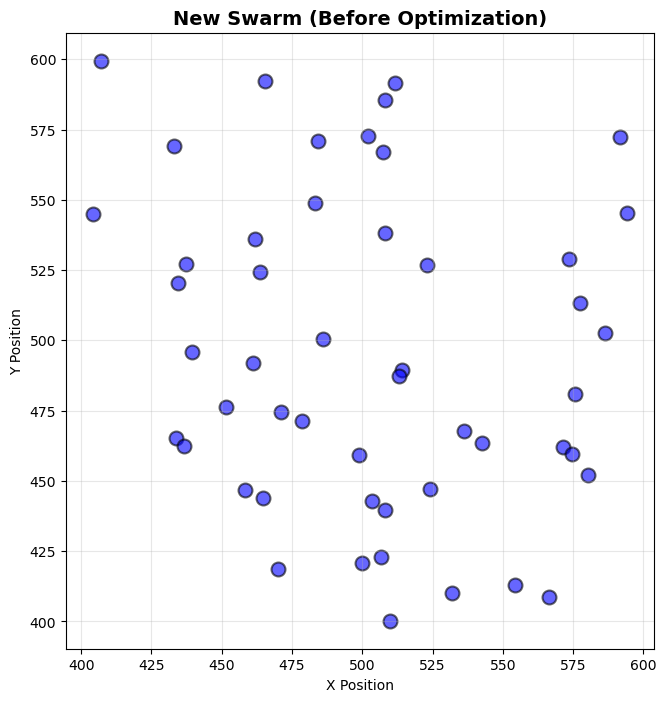

In [19]:
# Generate a new swarm (or load your own)
new_num_agents = 50
new_positions = generate_agent_positions(new_num_agents, GRID_SIZE)

# Build graph structure
distances = np.linalg.norm(new_positions[:, None, :] - new_positions[None, :, :], axis=-1)
W = (distances < MAX_DISTANCE).astype(float)
np.fill_diagonal(W, 0)
edge_index = torch.tensor(np.array(np.nonzero(W)), dtype=torch.long)

# Create Data object
x = torch.tensor(new_positions, dtype=torch.float)
new_data = Data(x=x, edge_index=edge_index)
new_data.original_positions = torch.tensor(new_positions, dtype=torch.float)
new_data = add_graph_features(new_data, MAX_DISTANCE)

print(f"New swarm: {new_num_agents} agents")

# Visualize original
visualize_swarm(new_positions, title="New Swarm (Before Optimization)")
plt.show()

Testing on all test graphs...

Example Losses - Domain of Danger: 0.5252,  Diffusion: 0.7939
Example Losses - Domain of Danger: 0.5187,  Diffusion: 0.9996
Example Losses - Domain of Danger: 0.5270,  Diffusion: 0.7407
Example Losses - Domain of Danger: 0.5150,  Diffusion: 1.0863
Example Losses - Domain of Danger: 0.5297,  Diffusion: 0.9261
Example Losses - Domain of Danger: 0.5200,  Diffusion: 1.0770
Example Losses - Domain of Danger: 0.5312,  Diffusion: 1.0075
Example Losses - Domain of Danger: 0.5242,  Diffusion: 1.2673
Example Losses - Domain of Danger: 0.5303,  Diffusion: 0.9562
Example Losses - Domain of Danger: 0.5206,  Diffusion: 1.0861
Example Losses - Domain of Danger: 0.5325,  Diffusion: 0.9753
Example Losses - Domain of Danger: 0.5194,  Diffusion: 1.1156
Example Losses - Domain of Danger: 0.5316,  Diffusion: 0.9444
Example Losses - Domain of Danger: 0.5208,  Diffusion: 1.2101
Example Losses - Domain of Danger: 0.5304,  Diffusion: 0.8901
Example Losses - Domain of Danger: 0.52

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_72126/2655916546.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Category", y="Values", data=df, inner="quartile", palette="muted")


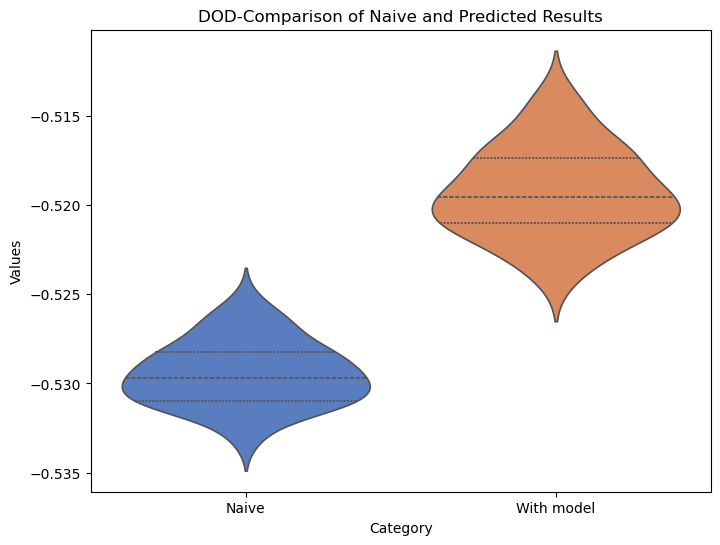

/var/folders/yk/yt973zks3y50tkwcqhndwqrm0000gn/T/ipykernel_72126/2655916546.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Category", y="Values", data=df, inner="quartile", palette="muted")


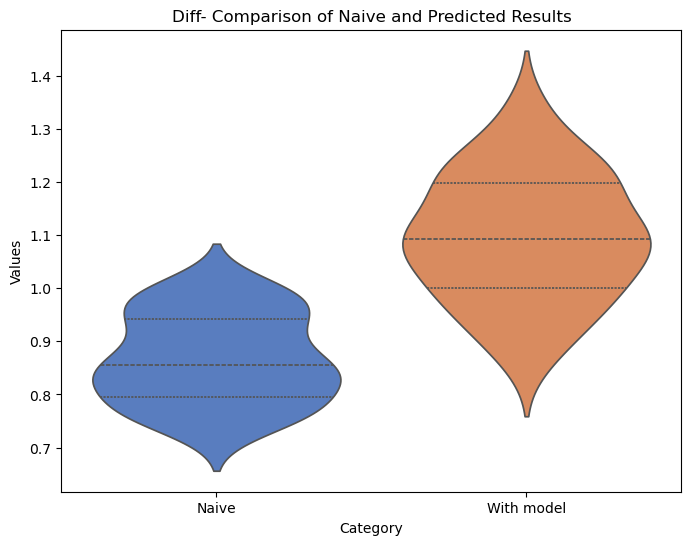

In [20]:
dod_op =[]
dod_or =[]
diff_op = []
diff_or = []
import shapes


# Test on all test graphs and compute average displacement
model.eval()

all_displacements = []

print("Testing on all test graphs...\n")
domain_loss_fn = DomainOfDangerLoss(50, 1000)
minimal_loss_fn = MinimalChangeLoss()
diffusion_loss_fn = DiffusionLoss([1,5,10], 50)

with torch.no_grad():
    for idx, test_graph in enumerate(test_graphs):
        test_graph = test_graph.to(device)
        original_positions = test_graph.original_positions
        optimized_positions, _, _ = model(test_graph.x, test_graph.edge_index)
        

        dod_loss = domain_loss_fn(original_positions)
        dod_or.append(-1*float(dod_loss.detach().numpy()))
        #mc_loss = minimal_loss_fn(original_positions, original_positions)
        diff_loss = diffusion_loss_fn(original_positions)
        diff_or.append(float(diff_loss.detach().numpy()))
    
        #diff_loss = diffusion_loss_fn(original_positions)
    
        print(f"Example Losses - Domain of Danger: {dod_loss:.4f},  Diffusion: {diff_loss:.4f}")
    
        #visualize_swarm(optimized_positions)
        dod_loss = domain_loss_fn(optimized_positions)
        #mc_loss = minimal_loss_fn(original_positions, optimized_positions)
        diff_loss = diffusion_loss_fn(optimized_positions)
        dod_op.append(-1*float(dod_loss.detach().numpy()))
        diff_op.append(float(diff_loss.detach().numpy()))
        print(f"Example Losses - Domain of Danger: {dod_loss:.4f},  Diffusion: {diff_loss:.4f}")




detached_op_dod= dod_op
detached_or_dod = dod_or

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Example data
# res_array_naive = [1, 2, 3, 4, 5]
# res_array_predicted = [2, 3, 4, 5, 6]

# Prepare the data
data = {
    "Values": detached_or_dod + detached_op_dod,
    "Category": ["Naive"] * len(detached_or_dod) + ["With model"] * len(detached_op_dod)
}
df = pd.DataFrame(data)

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x="Category", y="Values", data=df, inner="quartile", palette="muted")
plt.title("DOD-Comparison of Naive and Predicted Results")
plt.xlabel("Category")
plt.ylabel("Values")
plt.show()



detached_op_diff= diff_op
detached_or_diff = diff_or

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Example data
# res_array_naive = [1, 2, 3, 4, 5]
# res_array_predicted = [2, 3, 4, 5, 6]

# Prepare the data
data = {
    "Values": detached_or_diff + detached_op_diff,
    "Category": ["Naive"] * len(detached_or_diff) + ["With model"] * len(detached_op_diff)
}
df = pd.DataFrame(data)

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x="Category", y="Values", data=df, inner="quartile", palette="muted")
plt.title("Diff- Comparison of Naive and Predicted Results")
plt.xlabel("Category")
plt.ylabel("Values")
plt.show()



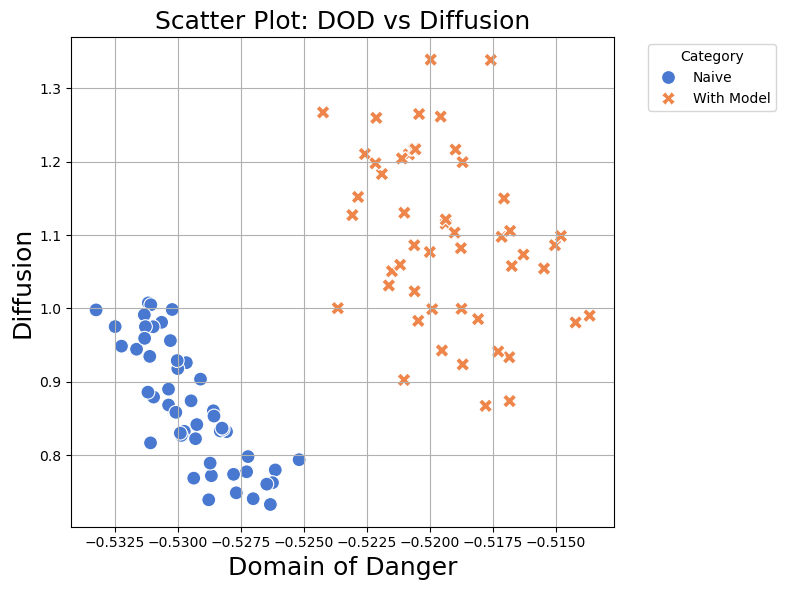

In [21]:
scatter_data = pd.DataFrame({
    "DOD": dod_or + dod_op,
    "Diffusion": diff_or + diff_op,
    "Category": ["Naive"] * len(dod_or) + ["With Model"] * len(dod_op)
})

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=scatter_data, x="DOD", y="Diffusion", hue="Category", style="Category", palette="muted", s=100)
plt.title("Scatter Plot: DOD vs Diffusion", fontsize=18)
plt.xlabel("Domain of Danger", fontsize=18)
plt.ylabel("Diffusion" , fontsize=18)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


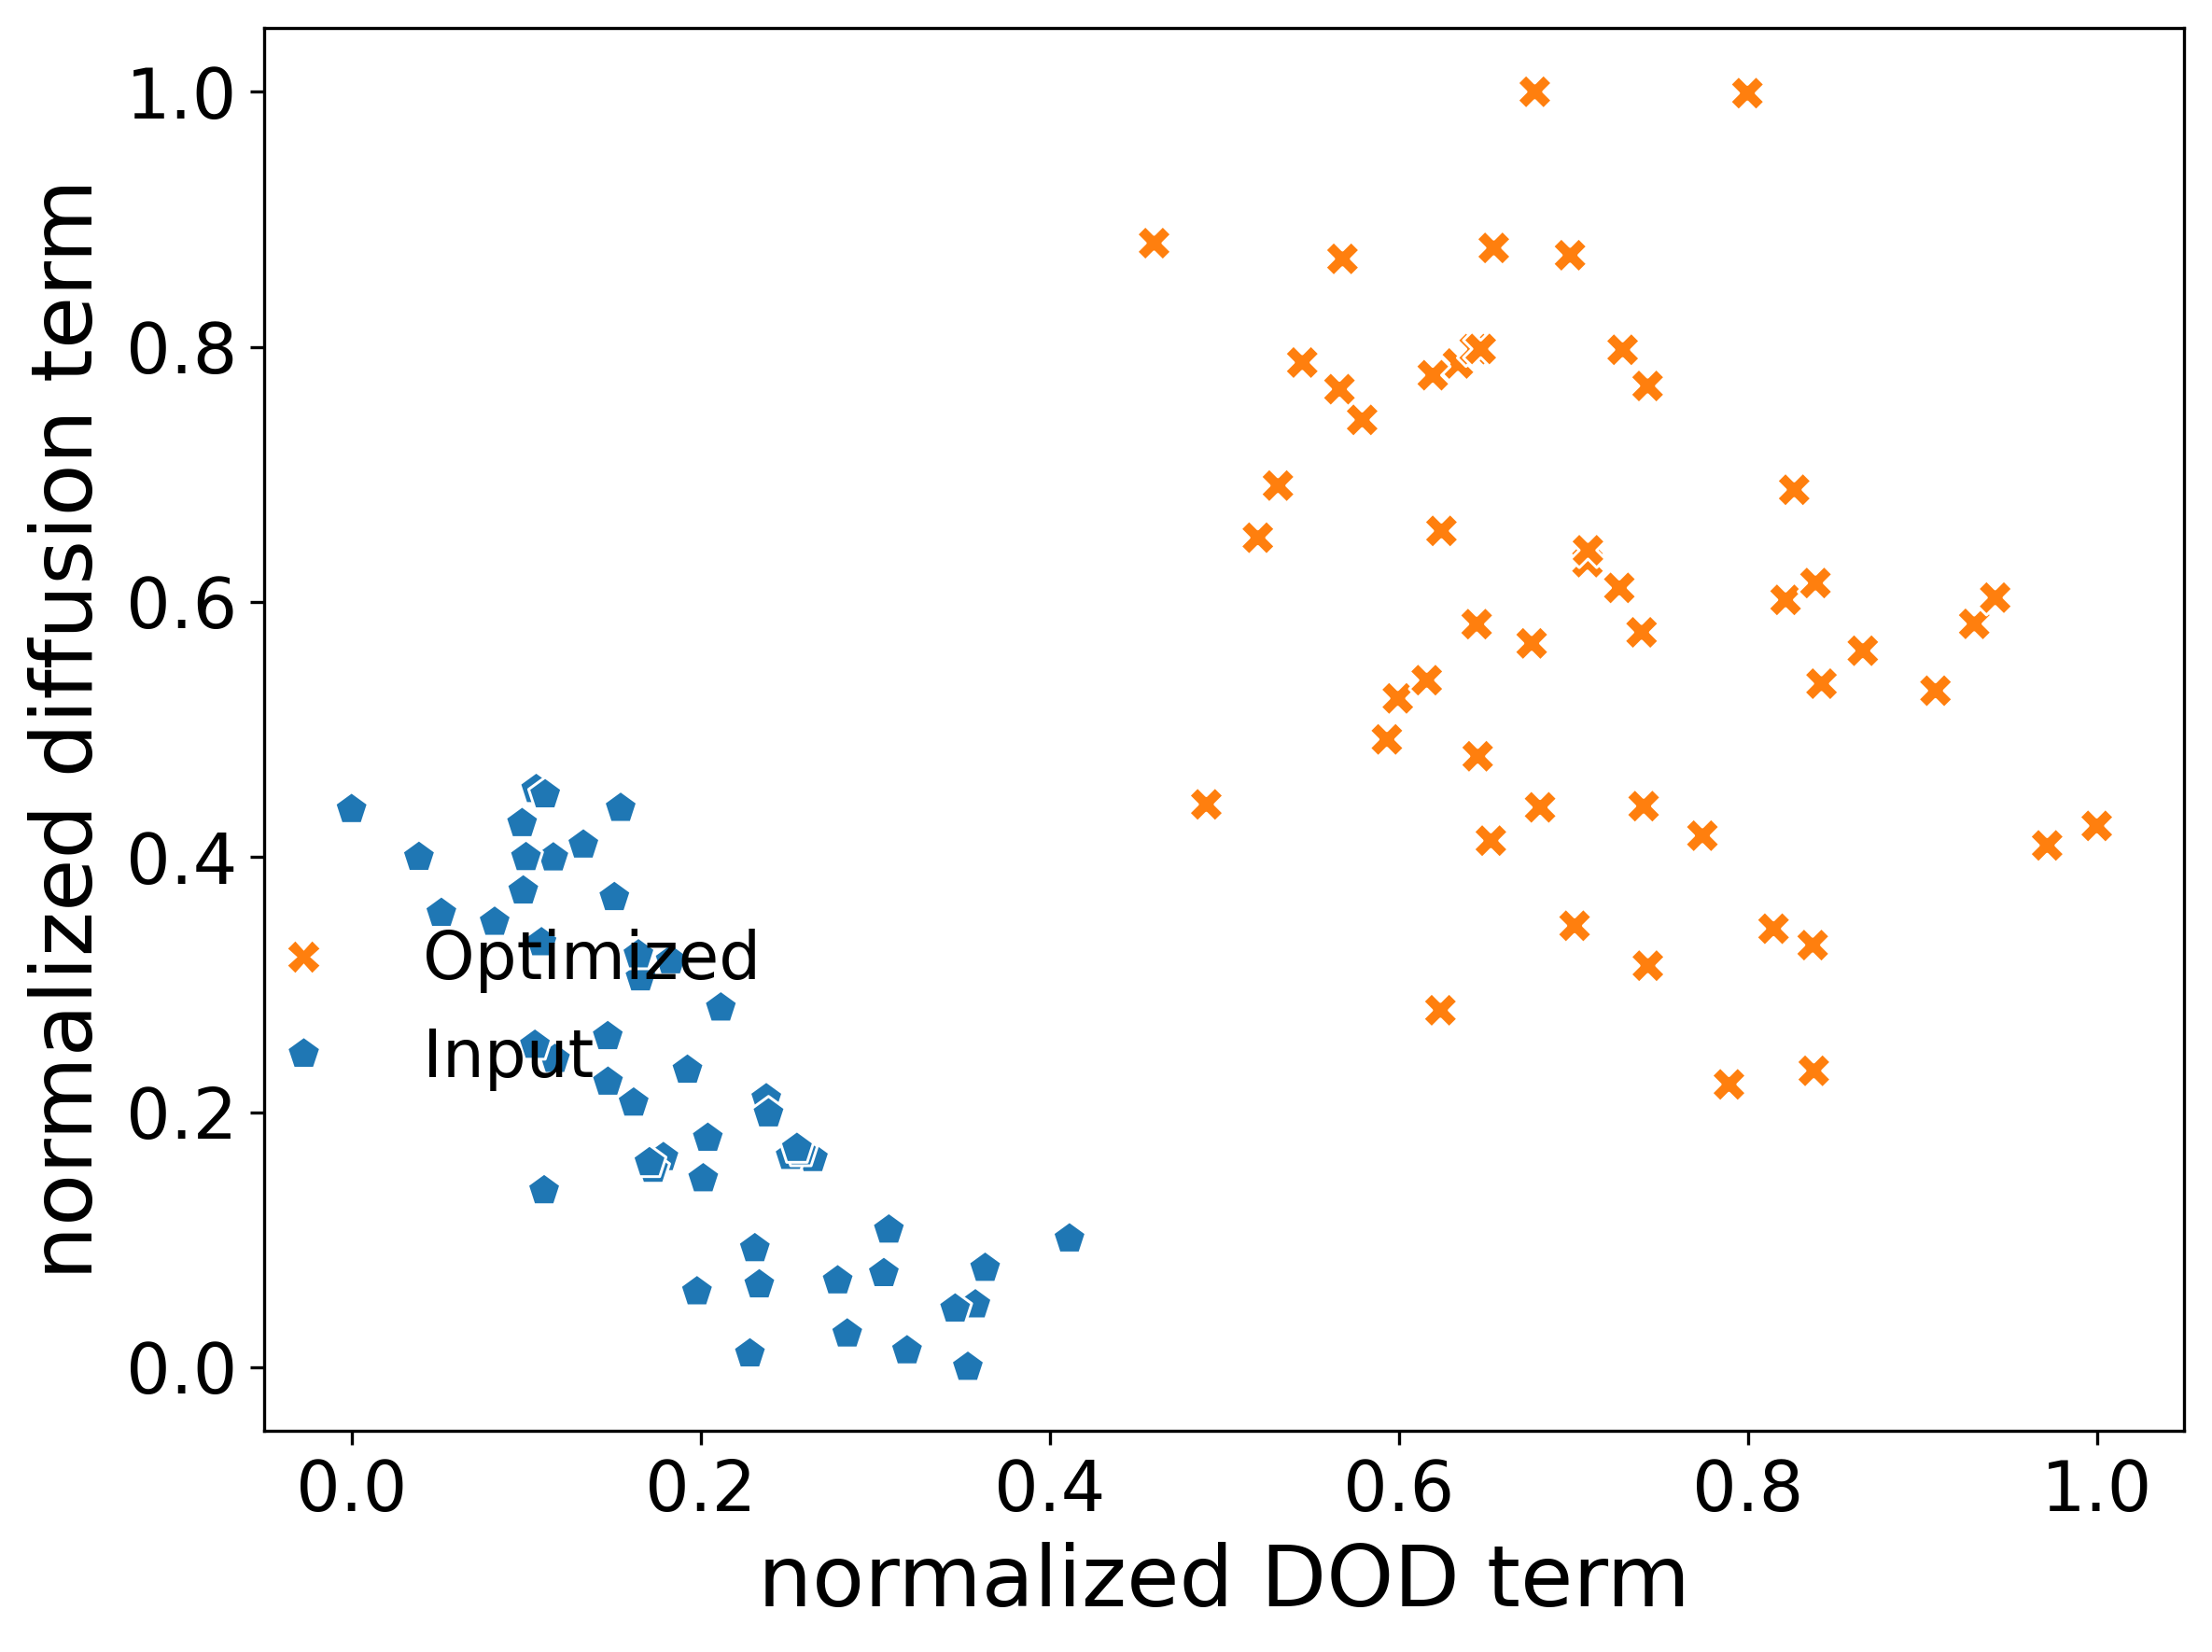

In [22]:
def normalize_ax(value1, value2):

    # Normalize values
    normalized_value1 = (value1 - np.min(value1)) / (np.max(value1) - np.min(value1))
    normalized_value2 = (value2 - np.min(value2)) / (np.max(value2) - np.min(value2))

    # Define weights
    w1 = 0.5
    w2 = 0.5

    # Calculate scores
    scores = w1 * normalized_value1 + w2 * normalized_value2

    # Determine the optimal index
    optimal_index = np.argmax(scores)
    optimal_value1 = value1[optimal_index]
    optimal_value2 = value2[optimal_index]

    #print(f"Optimal index: {optimal_index}")
    #print(f"Optimal value1: {optimal_value1}, Optimal value2: {optimal_value2}")
    return normalized_value1, normalized_value2
plt.figure(figsize=(8, 6), dpi=300)
dod_array = np.array(dod_or + dod_op)
diff_array = np.array(diff_or + diff_op)
normalized_dod, normalized_diff = normalize_ax(dod_array,diff_array)
scatter_data = pd.DataFrame({
    "DOD": normalized_dod,
    "Diffusion": normalized_diff,
    "Category": ["Input"] * len(dod_or) + ["Optimized"] * len(dod_op)
    
})

# Create scatter plot
sns.scatterplot(
    data=scatter_data,
    x="DOD",
    y="Diffusion",
    hue="Category",
    style="Category",
    palette={"Input": "#1f77b4", "Optimized": "#ff7f0e"},  # Custom colors
    s=80,  # Smaller point size for a clean look
    markers={"Input": "p", "Optimized": "X"}  # X for random, o for generated
)

# Label the axes with slightly smaller, modern fonts
plt.ylabel("normalized diffusion term", fontsize=22)
plt.xlabel("normalized DOD term", fontsize=22)

# Add a title with more subtle emphasis
#plt.title("Swarm Diffusion vs. Domain of Danger", fontsize=16, weight='bold', pad=10)

# Swap and relabel the legend
legend_labels = {"Input": "Input", "Optimized": "Optimized"}
handles, labels = plt.gca().get_legend_handles_labels()
new_handles = [handles[1], handles[0]]  # Swap order
new_labels = [legend_labels[labels[1]], legend_labels[labels[0]]]
plt.legend(
    new_handles,
    new_labels,
    fontsize=17,
    title_fontsize=12.5,
    loc="lower left",
    bbox_to_anchor=(-0.045, 0.2),  # Moves the legend 20% higher
    frameon=False
)
plt.style.use(['default'])

# Remove ticks for a minimalistic style
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim([min(scatter_data['Diffusion'])-0.05,max(scatter_data['Diffusion'])+0.05])
plt.xlim([min(scatter_data['DOD'])-0.05,max(scatter_data['DOD'])+0.05])
# Add a light grid for clarity
#plt.grid(True, alpha=0.2, linestyle="--")

# Optimize layout and show the plot
plt.tight_layout()
plt.show()


---

# Summary

## What We Did:

1. ✅ Generated a dataset of swarm graphs
2. ✅ Defined a Graph Neural Network (GNN) with VAE architecture
3. ✅ Trained the GNN to optimize swarm positions
4. ✅ Visualized training progress
5. ✅ Tested on new swarms
6. ✅ Saved the trained model

## Key Points:

- **GNN learns a function** to transform any swarm positions
- **Can generalize** to new, unseen swarms
- **Fast inference** after training (single forward pass)
- **Requires training** on multiple examples

## Parameters to Tune:

- `EPOCHS`: More epochs = better training
- `LEARNING_RATE`: Higher = faster but less stable
- `ALPHA, BETA, GAMMA, DELTA, EPSILON`: Loss weights
- `HIDDEN_DIM, LATENT_DIM`: Model capacity

---

## 🎉 That's it!

You've trained a GNN to optimize swarms. The model can now optimize any new swarm instantly!